# Projeto Controle Fuzzy PD para Quadricópteros

In [279]:
#!pip install -U scikit-fuzzy

In [280]:
import re                       # Suporte para expressões regulares.
import itertools                # Suporte para iterações em arrays.
import numpy as np              # Suporte para arrays e operações matemáticas.
import pandas as pd             # Suporte para manipulação de DataFrames.
import skfuzzy as fuzzy         # Suporte para operação com Lógica Fuzzy.
from tabulate import tabulate   # Suporte para manipulação de Tabelas.
import skfuzzy.control as ctrl  # Suporte para manipulação de Sistemas Fuzzy.
import matplotlib.pyplot as plt # Suporte para visualização de gráficos.

# Definição do universo das variáveis

Erro (𝑒):

Muito Pequeno (MP): O erro é muito pequeno, próximo do setPoint.

Pequeno (P): O erro é pequeno, distância pequena do setPoint.

Médio (M): O erro está moderado, distância intermediária do setPoint.

Grande (G): O erro é grande, distância alta do setPoint.

Muito Grande (MG): O erro é muito grande, muito longe do setPoint.


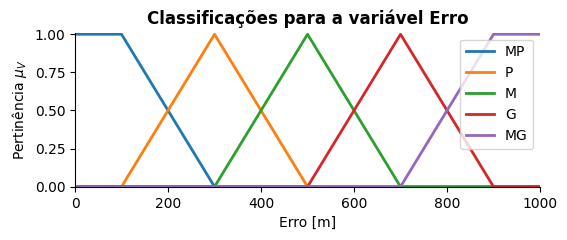

In [281]:
# Definição da variável Antecedente Erro 0:1000 m
Erro = ctrl.Antecedent(universe=np.arange(0, 1001, 1), label='Erro')

# Classificações de Erro
Erro['MP'] = fuzzy.trapmf(Erro.universe, [0, 0, 100, 300])
Erro['P'] = fuzzy.trimf(Erro.universe, [100, 300, 500])
Erro['M'] = fuzzy.trimf(Erro.universe, [300, 500, 700])
Erro['G'] = fuzzy.trimf(Erro.universe, [500, 700, 900])
Erro['MG'] = fuzzy.trapmf(Erro.universe, [700, 900, 1000, 1000])

Erro.view()   # Método para visualização da Função de Pertinência.
[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]

fig = plt.gcf(); axes = fig.gca(); fig.set_size_inches(6, 2)
axes.set_xlabel(xlabel=f'{Erro.label} [m]'); axes.set_ylabel(ylabel=r'Pertinência $\mu_{V}$')
plt.title(f'Classificações para a variável {Erro.label}', fontweight='bold'); plt.legend(loc='upper right')

Variação do Erro (Δ𝑒):

Muito Pequena (MP): A variacao do erro é muito pequena.

Pequena (P): A variacao do erro é pequena.

Médio (M): A variacao do erro é intermediária.

Grande (G): A variacao do erro é grande.

Muito Grande (MG): A variacao do erro é muito grande.

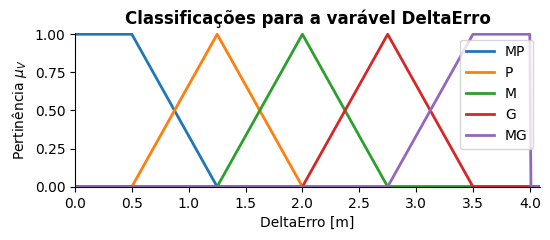

In [282]:
# Definição da variável Antecedente DeltaErro 0:4 m
DeltaErro = ctrl.Antecedent(universe=np.arange(0, 4.1, 0.01), label='DeltaErro')

# Classificações de DeltaErro
DeltaErro['MP'] = fuzzy.trapmf(DeltaErro.universe, [0, 0, 0.5, 1.25])
DeltaErro['P'] = fuzzy.trimf(DeltaErro.universe, [0.5, 1.25, 2])
DeltaErro['M'] = fuzzy.trimf(DeltaErro.universe, [1.25, 2, 2.75])
DeltaErro['G'] = fuzzy.trimf(DeltaErro.universe, [2, 2.75, 3.5])
DeltaErro['MG'] = fuzzy.trapmf(DeltaErro.universe, [2.75, 3.5, 4, 4])

DeltaErro.view()   # Método para visualização da Função de Pertinência.
[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]

fig = plt.gcf(); axes = fig.gca(); fig.set_size_inches(6, 2)
axes.set_xlabel(xlabel='DeltaErro [m]'); axes.set_ylabel(ylabel=r'Pertinência $\mu_{V}$');
plt.title(f'Classificações para a varável {DeltaErro.label}', fontweight='bold'); plt.legend(loc='upper right');

Potência do Motor (𝑃𝑀𝑜𝑡𝑜𝑟):

Muito Baixa (MB): Potência muito baixa.

Baixa (B): Potência baixa.

Média (M): Potência média.

Alta (A): Potência alta.

Muito Alta (MA): Potência muito alta.


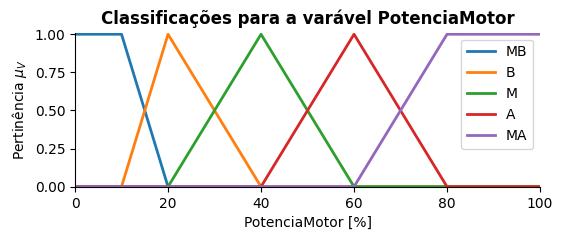

In [283]:
# Definição da variável Consequente PotenciaMotor 0:100%
PotenciaMotor = ctrl.Consequent(universe=np.arange(0, 101, 1), label='PotenciaMotor')

# Classificações de PotenciaMotor
PotenciaMotor['MB'] = fuzzy.trapmf(PotenciaMotor.universe, [0, 0, 10, 20])
PotenciaMotor['B'] = fuzzy.trimf(PotenciaMotor.universe, [10, 20, 40])
PotenciaMotor['M'] = fuzzy.trimf(PotenciaMotor.universe, [20, 40, 60])
PotenciaMotor['A'] = fuzzy.trimf(PotenciaMotor.universe, [40, 60, 80])
PotenciaMotor['MA'] = fuzzy.trapmf(PotenciaMotor.universe, [60, 80, 100, 100])

PotenciaMotor.view()   # Método para visualização da Função de Pertinência.
[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]

fig = plt.gcf(); axes = fig.gca(); fig.set_size_inches(6, 2)
axes.set_xlabel(xlabel='PotenciaMotor [%]'); axes.set_ylabel(ylabel=r'Pertinência $\mu_{V}$');
plt.title(f'Classificações para a varável {PotenciaMotor.label}', fontweight='bold'); plt.legend(loc='upper right');

# Base de Regras

In [284]:
# Base de Regras
BaseRegras = [
    ctrl.Rule(Erro['MP'] & DeltaErro['MP'], PotenciaMotor['B']),
    ctrl.Rule(Erro['MP'] & DeltaErro['P'], PotenciaMotor['B']),
    ctrl.Rule(Erro['MP'] & DeltaErro['M'], PotenciaMotor['MB']),
    ctrl.Rule(Erro['MP'] & DeltaErro['G'], PotenciaMotor['MB']),
    ctrl.Rule(Erro['MP'] & DeltaErro['MG'], PotenciaMotor['MB']),

    ctrl.Rule(Erro['P'] & DeltaErro['MP'], PotenciaMotor['M']),
    ctrl.Rule(Erro['P'] & DeltaErro['P'], PotenciaMotor['M']),
    ctrl.Rule(Erro['P'] & DeltaErro['M'], PotenciaMotor['B']),
    ctrl.Rule(Erro['P'] & DeltaErro['G'], PotenciaMotor['B']),
    ctrl.Rule(Erro['P'] & DeltaErro['MG'], PotenciaMotor['B']),

    ctrl.Rule(Erro['M'] & DeltaErro['MP'], PotenciaMotor['A']),
    ctrl.Rule(Erro['M'] & DeltaErro['P'], PotenciaMotor['A']),
    ctrl.Rule(Erro['M'] & DeltaErro['M'], PotenciaMotor['M']),
    ctrl.Rule(Erro['M'] & DeltaErro['G'], PotenciaMotor['M']),
    ctrl.Rule(Erro['M'] & DeltaErro['MG'], PotenciaMotor['M']),

    ctrl.Rule(Erro['G'] & DeltaErro['MP'], PotenciaMotor['MA']),
    ctrl.Rule(Erro['G'] & DeltaErro['P'], PotenciaMotor['MA']),
    ctrl.Rule(Erro['G'] & DeltaErro['M'], PotenciaMotor['A']),
    ctrl.Rule(Erro['G'] & DeltaErro['G'], PotenciaMotor['A']),
    ctrl.Rule(Erro['G'] & DeltaErro['MG'], PotenciaMotor['A']),
    
    ctrl.Rule(Erro['MG'] & DeltaErro['MP'], PotenciaMotor['MA']),
    ctrl.Rule(Erro['MG'] & DeltaErro['P'], PotenciaMotor['MA']),
    ctrl.Rule(Erro['MG'] & DeltaErro['M'], PotenciaMotor['MA']),
    ctrl.Rule(Erro['MG'] & DeltaErro['G'], PotenciaMotor['MA']),
    ctrl.Rule(Erro['MG'] & DeltaErro['MG'], PotenciaMotor['MA']),
]



In [285]:
ciano = '\033[96m'  # Define a cor azul-ciano

tabela = []
for erro in Erro.terms:  # Itera sobre os termos de classificação da variável Erro.
    for deltaErro in DeltaErro.terms:  # Itera sobre os termos de classificação da variável DeltaErro.
        for regra in BaseRegras:  # Itera sobre todas as regras da base.
            antecedente = str(regra).split('IF ')[1].split(' THEN')[0].replace('AND ', '')
            consequente = str(regra).split('IF ')[1].split(' THEN')[1].split('AND ')[0]

            # Encontra os classificadores (termos fuzzy) no texto da regra.
            classificacoes = re.findall(r'\[(.*?)\]', (antecedente + consequente))
            if erro == classificacoes[0] and deltaErro == classificacoes[1]:
                tabela.append([classificacoes[0], classificacoes[1], classificacoes[2]])
                break

# Cria um DataFrame com os dados da tabela.
df = pd.DataFrame(tabela, columns=[Erro.label, DeltaErro.label, PotenciaMotor.label])

# Cria a tabela pivô para organização visual.
pivotTable = pd.DataFrame(df.pivot(index=DeltaErro.label, columns=Erro.label, values=PotenciaMotor.label)
                          .reindex(index=DeltaErro.terms, columns=Erro.terms))

# Nomeia o índice e aplica formatação colorida.
pivotTable.index.name = f"{ciano}E\033[0m"

# Exibe a tabela formatada.
print(tabulate(pivotTable, headers='keys', tablefmt='fancy_grid', stralign='center', showindex='always'), end='\n\n')


╒═════╤══════╤═════╤═════╤═════╤══════╕
│  E  │  MP  │  P  │  M  │  G  │  MG  │
╞═════╪══════╪═════╪═════╪═════╪══════╡
│ MP  │  B   │  M  │  A  │ MA  │  MA  │
├─────┼──────┼─────┼─────┼─────┼──────┤
│  P  │  B   │  M  │  A  │ MA  │  MA  │
├─────┼──────┼─────┼─────┼─────┼──────┤
│  M  │  MB  │  B  │  M  │  A  │  MA  │
├─────┼──────┼─────┼─────┼─────┼──────┤
│  G  │  MB  │  B  │  M  │  A  │  MA  │
├─────┼──────┼─────┼─────┼─────┼──────┤
│ MG  │  MB  │  B  │  M  │  A  │  MA  │
╘═════╧══════╧═════╧═════╧═════╧══════╛



# Definindo uma regra qualquer e observando como ela é interpretada.


Graus de pertinência para Erro:
  - P: 0.50
  - M: 0.50

Graus de pertinência para DeltaErro:
  - M: 1.00

Classificações da variável de saída (PotenciaMotor):
  - B: 0.31
  - M: 0.69

Valor final da PotenciaMotor: 33.82%


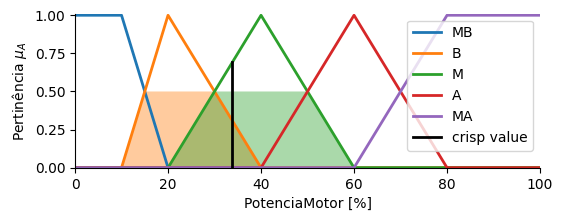

In [287]:
# Configurando o sistema de controle
ControleErro = ctrl.ControlSystemSimulation(ctrl.ControlSystem(BaseRegras))

# Definindo entradas para Erro e DeltaErro
ControleErro.input[Erro.label] = 400  # valor desejado para Erro
ControleErro.input[DeltaErro.label] = 2  # valor desejado para DeltaErro

# Realiza o cálculo do sistema fuzzy
ControleErro.compute()

# Graus de pertinência para a variável Erro
print(f"\nGraus de pertinência para {Erro.label}:")
ativacaoErro = []  # Lista de regiões ativadas para o Erro
for erro_nome, erro_mf in Erro.terms.items():
    uV = fuzzy.interp_membership(Erro.universe, erro_mf.mf, ControleErro._get_inputs()[Erro.label])
    if uV > 0:
        print(f"  - {erro_nome}: {uV:.2f}")
        ativacaoErro.append(erro_nome)

# Graus de pertinência para a variável DeltaErro
print(f"\nGraus de pertinência para {DeltaErro.label}:")
ativacaoDeltaErro = []  # Lista de regiões ativadas para o DeltaErro
for delta_nome, delta_mf in DeltaErro.terms.items():
    uI = fuzzy.interp_membership(DeltaErro.universe, delta_mf.mf, ControleErro._get_inputs()[DeltaErro.label])
    if uI > 0:
        print(f"  - {delta_nome}: {uI:.2f}")
        ativacaoDeltaErro.append(delta_nome)

# Valor da variável de saída (PotenciaMotor)
print(f"\nClassificações da variável de saída ({PotenciaMotor.label}):")
for termo_nome, termo_mf in PotenciaMotor.terms.items():
    uA = fuzzy.interp_membership(PotenciaMotor.universe, termo_mf.mf, ControleErro.output[PotenciaMotor.label])
    if uA > 0:
        print(f"  - {termo_nome}: {uA:.2f}")

# Exibição gráfica da saída
PotenciaMotor.view(sim=ControleErro)
[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]

fig = plt.gcf(); axes = fig.gca(); fig.set_size_inches(6, 2)
axes.set_xlabel(xlabel=f"{PotenciaMotor.label} [%]"); axes.set_ylabel(ylabel=r"Pertinência $\mu_{A}$")
plt.legend(loc='upper right')

# Resultado final da Potência do Motor
print(f"\nValor final da {PotenciaMotor.label}: {ControleErro.output[PotenciaMotor.label]:.2f}%")
